# Comparative Sentiment Analysis of Movie Reviews: Insight from Natural Language Processing

#### PROBLEM STATEMENT

### Import Necessary Libraries

In [1]:
from collections import defaultdict
import math
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### Import dataset 

In [2]:
#Import dataset
df = pd.read_csv('IMDB dataset.csv')

### Display the dataframe 

In [3]:
# Display the dataframe 
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


**Interpretation: It could be observed that the dataset comprises of two (2) columns i.e. review and sentiment**

### Counts the number of positive and negative reviews 

In [4]:
# counts the number of positive and negative reviewd 
df['sentiment'].value_counts()   #codes derive from https://iq.opengenus.org/naive-bayes-sentiment-analysis/

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

**Interpretation: the dataset comprises 25000 each of positive and negative reviews**

### Data Preprocessing

In [5]:
#drop empty column
df.dropna(inplace=True)

In [6]:
#check for blanks
blanks = []
for i, lb, rv in df.itertuples():
    if type (rv) == str:
        if rv.isspace():
            blanks.append(i)

In [7]:
blanks

[]

### Lemmatization 

In [8]:
# Note all the codes below were derived from https://iq.opengenus.org/naive-bayes-sentiment-analysis/

lemmatizer = WordNetLemmatizer() # Initialize lemmatizer

# word_counts[word][0] = occurrences of word in negative reviews
# word_counts[word][1] = occurrences of word in positive reviews
word_counts = defaultdict(lambda: [0, 0]) # returns [0, 0] by default if the key do not exist

STOP_WORDS = stopwords.words('english')  #Load list of stopwords

tokenizer = RegexpTokenizer(r'\w+') # Initialize tokenizer to split text into words

sentiment = list(df['sentiment']) # Convert 'sentiment' column of DataFrame to a list

done =  0 # Initialize done counter

total_positive_words = 0 # Initialize counter for total positive words
total_negative_words = 0  # Initialize counter for total negative words

# keep track of the number of positive and negative reviews (prior probabilities)
total_positive_reviews = 0 # Initialize counter for total positive reviews
total_negative_reviews = 0  # Initialize counter for total negative reviews

### Processing reviews to count word occurrences

In [9]:
# Note all the codes below were derived from https://iq.opengenus.org/naive-bayes-sentiment-analysis/

for i, review in enumerate(list(df['review'])):  # Iterate over each review and its index
    if sentiment[i] == 'positive':  # Check if the current review is positive
        total_positive_reviews += 1  # Increment positive review counter
    else:  # Otherwise, the review is negative
        total_negative_reviews += 1  # Increment negative review counter
    
    for token in tokenizer.tokenize(review):  # Tokenize the review into individual words
        token = token.lower()  # Convert the token to lowercase
        token = lemmatizer.lemmatize(token)  # Lemmatize the token
        if token not in STOP_WORDS:  # Check if the token is not a stop word
            if sentiment[i] == 'positive':  # If the review is positive
                word_counts[token][1] += 1  # Increment positive occurrence count for the token
                total_positive_words += 1  # Increment total positive word counter
            else:  # Otherwise, the review is negative
                word_counts[token][0] += 1  # Increment negative occurrence count for the token
                total_negative_words += 1  # Increment total negative word counter

### Sorting and trimming word count to top 5000


In [10]:
# Note all the codes below were derived from https://iq.opengenus.org/naive-bayes-sentiment-analysis/

word_counts = sorted(word_counts.items(),  # Sort the word_counts dictionary items
                     key=lambda x : x[1][0] + x[1][1],  # Sort by the sum of occurrences in both positive and negative reviews
                     reverse=True)[:5000]  # Take the top 5000 most frequent words


In [11]:
# Note all the codes below were derived from https://iq.opengenus.org/naive-bayes-sentiment-analysis/
word_counts = defaultdict(lambda: [0, 0], word_counts) # reinitialize word_counts as a defaultdict

### Function to Calculate Word Probability based on sentiment

In [12]:
# Note all the codes below were derived from https://iq.opengenus.org/naive-bayes-sentiment-analysis/

def calculate_word_probability(word, sentiment):  # Define function to calculate probability of a word given the sentiment
    if sentiment == 'positive':  # Check if the sentiment is positive
        return math.log((word_counts[word][1] + 1) /  # Calculate log probability of the word in positive reviews
                        (total_positive_words + 5000))  # Adjust for smoothing with total positive words plus vocabulary size
    else:  # Otherwise, the sentiment is negative
        return math.log((word_counts[word][0] + 1) /  # Calculate log probability of the word in negative reviews
                        (total_negative_words + 5000))  # Adjust for smoothing with total negative words plus vocabulary size


### Function to calculate review probability based on sentiment

In [13]:
# Note all the codes below were derived from https://iq.opengenus.org/naive-bayes-sentiment-analysis/

def calculate_review_probability(review, sentiment):  # Define function to calculate probability of a review given the sentiment
    if sentiment == 'positive':  # Check if the sentiment is positive
        probability = math.log(total_positive_reviews / len(df))  # Start with log prior probability of positive reviews
    else:  # Otherwise, the sentiment is negative
        probability = math.log(total_negative_reviews / len(df))  # Start with log prior probability of negative reviews
    
    for token in tokenizer.tokenize(review):  # Tokenize the review into individual words
        token = token.lower()  # Convert the token to lowercase
        token = lemmatizer.lemmatize(token)  # Lemmatize the token
        if token not in STOP_WORDS:  # Check if the token is not a stop word
            probability += calculate_word_probability(token, sentiment)  # Add the log probability of the word given the sentiment
    
    return probability  # Return the total log probability for the review

### Function to predict the sentiment of a review

In [14]:
# Note all the codes below were derived from https://iq.opengenus.org/naive-bayes-sentiment-analysis/

def predict(review):  # Define function to predict the sentiment of a given review
    if calculate_review_probability(review, 'positive') > calculate_review_probability(review, 'negative'): # Compare prob. for pos & neg sentiments
        return 'positive'  # Return 'positive' if the review is more likely positive
    else:  # Otherwise, the review is more likely negative
        return 'negative'  # Return 'negative'

### Predict reviews on the data that the model has not seen 

In [15]:
print(predict('This movie was enjoyable')) #predict review 
print(predict('Not so good... I found it somewhat boring')) #predict review

positive
negative


### Evaluate the accuracy of the model 

In [16]:
#Note all these codes were obtained from https://www.enjoyalgorithms.com/blog/sentiment-analysis-using-naive-bayes

# Function to predict sentiment based on the review text
def predict(review):
    positive_prob = calculate_review_probability(review, 'positive')
    negative_prob = calculate_review_probability(review, 'negative')
    return 'positive' if positive_prob > negative_prob else 'negative'

# Lists to store actual and predicted sentiments
actual_sentiments = list(df['sentiment'])
predicted_sentiments = []

# Iterate through each review and predict the sentiment
for review in list(df['review']):
    predicted_sentiments.append(predict(review))

# Calculate precision, recall, and F1 score
precision = precision_score(actual_sentiments, predicted_sentiments, pos_label='positive')
recall = recall_score(actual_sentiments, predicted_sentiments, pos_label='positive')
f1 = f1_score(actual_sentiments, predicted_sentiments, pos_label='positive')

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the overall accuracy for completeness
correct = sum(1 for i in range(len(actual_sentiments)) if actual_sentiments[i] == predicted_sentiments[i])
accuracy = correct / len(actual_sentiments)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.8906
Recall: 0.7953
F1 Score: 0.8403
Accuracy: 0.8488


**Interpretation Precision measures the proportion of true positive predictions among all positive predictions. From the output, the word counts Naive Bayes model shows a higher precision, 89.1% relative to the TF-IDF model, 85.1%. This suggests that the word count model is more superior to identifying positive reviews among those it predicts as positive.**

### Train and evaluate a Naive Bayes Model using TF-IDF 

In [17]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the review data to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['review'])

# Create the target variable
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data into training and test sets (e.g., 80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict the sentiments on the test set
y_pred = nb_classifier.predict(X_test)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.8506
Recall: 0.8551
F1 Score: 0.8528
Accuracy: 0.8513


**On the other hand, the TF-IDF model shows a higher recall, F1 score, and Accuracy values relative to the word counts model suggesting that the TF-IDF model is better at identifying actual positive reviews i.e. marginally performs better in terms of predictions and has demonstrated a better balance between precision and recall.**


### Train and evalaute a Support vector machine model using TF-IDF

**Note the codes below were derived from https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the review data to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['review'])

# Create the target variable
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

# Predict the sentiments on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.8750
Recall: 0.8972
F1 Score: 0.8859
Accuracy: 0.8836


**Interpretation: the output of the SVM suggests that the support vector machine has emulated the Naive Bayes model in terms of Precision, recall, F1 score, and Accuracy scores. This is could be due to the strong advantage of SVM to handle both linear and non-linear data.**

### Train and evalaute a Decision Tree model using TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the review data to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['review'])

# Create the target variable
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predict the sentiments on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.7232
Recall: 0.7162
F1 Score: 0.7197
Accuracy: 0.7189


**Interpretation: the output of the Decision Tree suggests that the it performs the worst among the models, with lower precision, recall, F1 score, and accuracy, all around 72%.**

### Train and evalaute a Logistics Regression model using TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the review data to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['review'])

# Create the target variable
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=42)
logreg_classifier.fit(X_train, y_train)

# Predict the sentiments on the test set
y_pred = logreg_classifier.predict(X_test)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.8791
Recall: 0.9059
F1 Score: 0.8923
Accuracy: 0.8898


C:\Users\sulbi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Interpretation: the output of the Logistics regression suggests that it performs similarly to SVM, with high precision, recall, F1 score, and accuracy, even though it is slightly better, particularly in recall.**

## Comparison of Model Parameters using Line Graphs

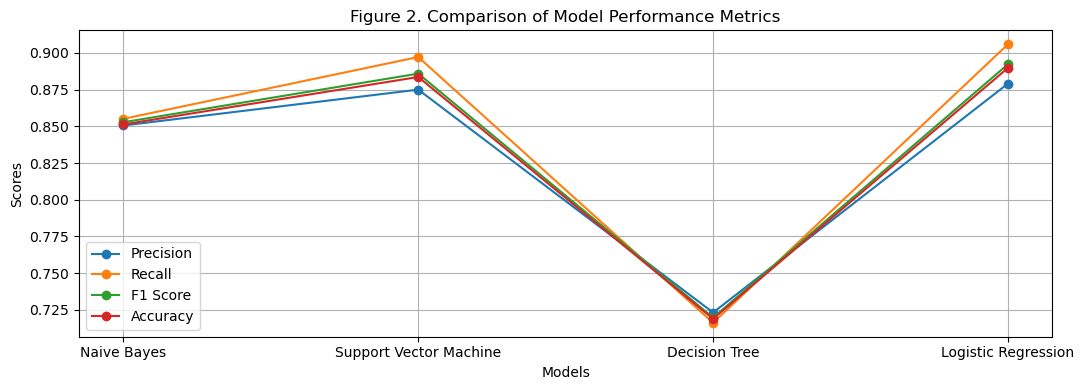

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics for each model
metrics = {
    'Naive Bayes': {'Precision': 0.8506, 'Recall': 0.8551, 'F1 Score': 0.8528, 'Accuracy': 0.8513},
    'Support Vector Machine': {'Precision': 0.8750, 'Recall': 0.8972, 'F1 Score': 0.8859, 'Accuracy': 0.8836},
    'Decision Tree': {'Precision': 0.7232, 'Recall': 0.7162, 'F1 Score': 0.7197, 'Accuracy': 0.7189},
    'Logistic Regression': {'Precision': 0.8791, 'Recall': 0.9059, 'F1 Score': 0.8923, 'Accuracy': 0.8898}
}

# Extract data for plotting
models = list(metrics.keys())
precision = [metrics[model]['Precision'] for model in models]
recall = [metrics[model]['Recall'] for model in models]
f1_score = [metrics[model]['F1 Score'] for model in models]
accuracy = [metrics[model]['Accuracy'] for model in models]

# Define the positions on the x-axis
x = np.arange(len(models))

# Plot the performance metrics
plt.figure(figsize=(11, 4))

plt.plot(x, precision, marker='o', label='Precision')
plt.plot(x, recall, marker='o', label='Recall')
plt.plot(x, f1_score, marker='o', label='F1 Score')
plt.plot(x, accuracy, marker='o', label='Accuracy')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Figure 2. Comparison of Model Performance Metrics')
plt.xticks(x, models)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## General Conclusion

**Logistic Regression which shows the highest precision, recall, F1 score, and accuracy is regarded as the best performing followed by the Support Vector Machine. However, the baseline model, Naive Baperformance even though it is superior to the Decision tree which demonstrated the lowest performance**

## References